In [30]:
# https://github.com/n15lind
# https://github.com/n15lind/HW6
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Initialize Dataset
num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Divide data into training, validation, and test sets
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# Create Scaler
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

# Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

# -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

# Train model
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

Training epoch 1
Error tensor(0.4706, device='cuda:0')
Training epoch 20
Error tensor(0.2232, device='cuda:0')
Training epoch 40
Error tensor(0.2179, device='cuda:0')
Training epoch 60
Error tensor(0.2107, device='cuda:0')
Training epoch 80
Error tensor(0.2054, device='cuda:0')
Training epoch 100
Error tensor(0.1943, device='cuda:0')
Training epoch 120
Error tensor(0.1805, device='cuda:0')
Training epoch 140
Error tensor(0.1741, device='cuda:0')
Training epoch 160
Error tensor(0.1613, device='cuda:0')
Training epoch 180
Error tensor(0.1534, device='cuda:0')
Training epoch 200
Error tensor(0.1451, device='cuda:0')
Training epoch 220
Error tensor(0.1380, device='cuda:0')
Training epoch 240
Error tensor(0.1332, device='cuda:0')
Training epoch 260
Error tensor(0.1293, device='cuda:0')
Training epoch 280
Error tensor(0.1257, device='cuda:0')
Training epoch 300
Error tensor(0.1273, device='cuda:0')
Training epoch 320
Error tensor(0.1203, device='cuda:0')
Training epoch 340
Error tensor(0.121

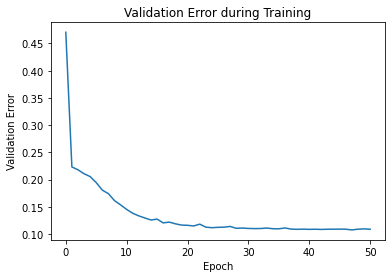

0.020010263


In [9]:
# Test model
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())

# Plot validation errors
plt.plot(validation_errors)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Validation Error during Training')
plt.show()

test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

Training epoch 1
Error tensor(0.4820, device='cuda:0')
Training epoch 20
Error tensor(0.2496, device='cuda:0')
Training epoch 40
Error tensor(0.2320, device='cuda:0')
Training epoch 60
Error tensor(0.2146, device='cuda:0')
Training epoch 80
Error tensor(0.2086, device='cuda:0')
Training epoch 100
Error tensor(0.2016, device='cuda:0')
Training epoch 120
Error tensor(0.1957, device='cuda:0')
Training epoch 140
Error tensor(0.1828, device='cuda:0')
Training epoch 160
Error tensor(0.1740, device='cuda:0')
Training epoch 180
Error tensor(0.1670, device='cuda:0')
Training epoch 200
Error tensor(0.1621, device='cuda:0')
Training epoch 220
Error tensor(0.1528, device='cuda:0')
Training epoch 240
Error tensor(0.1472, device='cuda:0')
Training epoch 260
Error tensor(0.1421, device='cuda:0')
Training epoch 280
Error tensor(0.1387, device='cuda:0')
Training epoch 300
Error tensor(0.1336, device='cuda:0')
Training epoch 320
Error tensor(0.1322, device='cuda:0')
Training epoch 340
Error tensor(0.129

Training epoch 80
Error tensor(0.2143, device='cuda:0')
Training epoch 100
Error tensor(0.2101, device='cuda:0')
Training epoch 120
Error tensor(0.2097, device='cuda:0')
Training epoch 140
Error tensor(0.1878, device='cuda:0')
Training epoch 160
Error tensor(0.1753, device='cuda:0')
Training epoch 180
Error tensor(0.1663, device='cuda:0')
Training epoch 200
Error tensor(0.1555, device='cuda:0')
Training epoch 220
Error tensor(0.1480, device='cuda:0')
Training epoch 240
Error tensor(0.1405, device='cuda:0')
Training epoch 260
Error tensor(0.1363, device='cuda:0')
Training epoch 280
Error tensor(0.1297, device='cuda:0')
Training epoch 300
Error tensor(0.1295, device='cuda:0')
Training epoch 320
Error tensor(0.1255, device='cuda:0')
Training epoch 340
Error tensor(0.1234, device='cuda:0')
Training epoch 360
Error tensor(0.1240, device='cuda:0')
Training epoch 380
Error tensor(0.1192, device='cuda:0')
Training epoch 400
Error tensor(0.1189, device='cuda:0')
Training epoch 420
Error tensor(

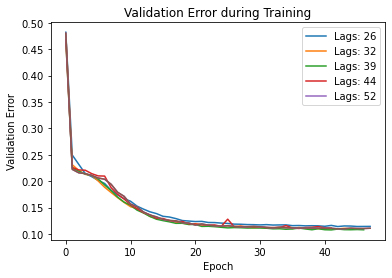

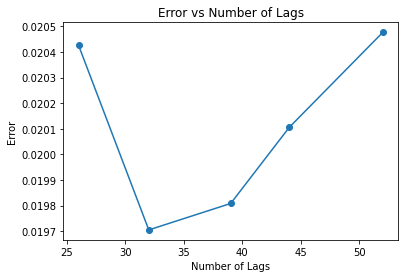

In [26]:
# Initialize Dataset
num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Divide data into training, validation, and test sets
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# Create Scaler
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Lists to store results
error_list = []

# Define lag values
lag_values = [26, 32, 39, 44, 52]  # Different lag values to test

for lags in lag_values:
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    # -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Evaluate performance on test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    error_list.append(error)
    
    # Plot validation errors
    plt.plot(validation_errors, label=f'Lags: {lags}')

# Plot validation errors
plt.plot(validation_errors)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Validation Error during Training')
plt.legend()
plt.show()

# Plot performance as a function of the number of Lags
plt.plot(lag_values, error_list, marker='o')
plt.xlabel('Number of Lags')
plt.ylabel('Error')
plt.title('Error vs Number of Lags')
plt.show()

Training epoch 1
Error tensor(0.4786, device='cuda:0')
Training epoch 20
Error tensor(0.2496, device='cuda:0')
Training epoch 40
Error tensor(0.2204, device='cuda:0')
Training epoch 60
Error tensor(0.2196, device='cuda:0')
Training epoch 80
Error tensor(0.2164, device='cuda:0')
Training epoch 100
Error tensor(0.2039, device='cuda:0')
Training epoch 120
Error tensor(0.1977, device='cuda:0')
Training epoch 140
Error tensor(0.1847, device='cuda:0')
Training epoch 160
Error tensor(0.1788, device='cuda:0')
Training epoch 180
Error tensor(0.1707, device='cuda:0')
Training epoch 200
Error tensor(0.1607, device='cuda:0')
Training epoch 220
Error tensor(0.1586, device='cuda:0')
Training epoch 240
Error tensor(0.1504, device='cuda:0')
Training epoch 260
Error tensor(0.1430, device='cuda:0')
Training epoch 280
Error tensor(0.1377, device='cuda:0')
Training epoch 300
Error tensor(0.1356, device='cuda:0')
Training epoch 320
Error tensor(0.1322, device='cuda:0')
Training epoch 340
Error tensor(0.132

Training epoch 200
Error tensor(0.2080, device='cuda:0')
Training epoch 220
Error tensor(0.2023, device='cuda:0')
Training epoch 240
Error tensor(0.1988, device='cuda:0')
Training epoch 260
Error tensor(0.1984, device='cuda:0')
Training epoch 280
Error tensor(0.1992, device='cuda:0')
Training epoch 300
Error tensor(0.1949, device='cuda:0')
Training epoch 320
Error tensor(0.1892, device='cuda:0')
Training epoch 340
Error tensor(0.1877, device='cuda:0')
Training epoch 360
Error tensor(0.1857, device='cuda:0')
Training epoch 380
Error tensor(0.1868, device='cuda:0')
Training epoch 400
Error tensor(0.1835, device='cuda:0')
Training epoch 420
Error tensor(0.1842, device='cuda:0')
Training epoch 440
Error tensor(0.1823, device='cuda:0')
Training epoch 460
Error tensor(0.1789, device='cuda:0')
Training epoch 480
Error tensor(0.1817, device='cuda:0')
Training epoch 500
Error tensor(0.1799, device='cuda:0')
Training epoch 520
Error tensor(0.1774, device='cuda:0')
Training epoch 540
Error tensor

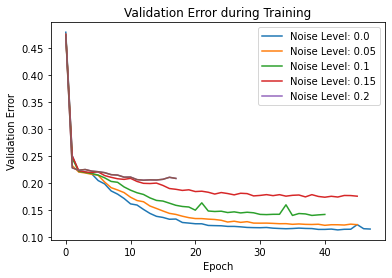

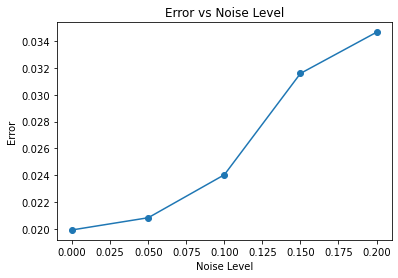

In [22]:
# Initialize Dataset
num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Divide data into training, validation, and test sets
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# Create Scaler
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

# Create noise
def add_gaussian_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, size=data.shape)
    noisy_data = data + noise
    return noisy_data

# Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

# Define noise levels to evaluate
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]

# Lists to store results
error_list = []

# Iterate over noise levels
for noise_level in noise_levels:
    # Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    # Add Gaussian noise to input data
    noisy_data_in = add_gaussian_noise(all_data_in, mean=0, std=noise_level)

    # Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(noisy_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(noisy_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(noisy_data_in[test_indices], dtype=torch.float32).to(device)

    # -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Evaluate performance on test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    error_list.append(error)
    
    # Plot validation errors
    plt.plot(validation_errors, label=f'Noise Level: {noise_level}')

# Plot validation errors
plt.plot(validation_errors)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Validation Error during Training')
plt.legend()
plt.show()

# Plot performance as a function of noise level
plt.plot(noise_levels, error_list, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Error')
plt.title('Error vs Noise Level')
plt.show()

Training epoch 1
Error tensor(0.4857, device='cuda:0')
Training epoch 20
Error tensor(0.2366, device='cuda:0')
Training epoch 40
Error tensor(0.2283, device='cuda:0')
Training epoch 60
Error tensor(0.2268, device='cuda:0')
Training epoch 80
Error tensor(0.2269, device='cuda:0')
Training epoch 100
Error tensor(0.2241, device='cuda:0')
Training epoch 120
Error tensor(0.2250, device='cuda:0')
Training epoch 140
Error tensor(0.2205, device='cuda:0')
Training epoch 160
Error tensor(0.2176, device='cuda:0')
Training epoch 180
Error tensor(0.2171, device='cuda:0')
Training epoch 200
Error tensor(0.2124, device='cuda:0')
Training epoch 220
Error tensor(0.2018, device='cuda:0')
Training epoch 240
Error tensor(0.1958, device='cuda:0')
Training epoch 260
Error tensor(0.1864, device='cuda:0')
Training epoch 280
Error tensor(0.1741, device='cuda:0')
Training epoch 300
Error tensor(0.1578, device='cuda:0')
Training epoch 320
Error tensor(0.1472, device='cuda:0')
Training epoch 340
Error tensor(0.141

Training epoch 80
Error tensor(0.1979, device='cuda:0')
Training epoch 100
Error tensor(0.1893, device='cuda:0')
Training epoch 120
Error tensor(0.1818, device='cuda:0')
Training epoch 140
Error tensor(0.1780, device='cuda:0')
Training epoch 160
Error tensor(0.1751, device='cuda:0')
Training epoch 180
Error tensor(0.1649, device='cuda:0')
Training epoch 200
Error tensor(0.1593, device='cuda:0')
Training epoch 220
Error tensor(0.1521, device='cuda:0')
Training epoch 240
Error tensor(0.1453, device='cuda:0')
Training epoch 260
Error tensor(0.1418, device='cuda:0')
Training epoch 280
Error tensor(0.1404, device='cuda:0')
Training epoch 300
Error tensor(0.1328, device='cuda:0')
Training epoch 320
Error tensor(0.1286, device='cuda:0')
Training epoch 340
Error tensor(0.1260, device='cuda:0')
Training epoch 360
Error tensor(0.1237, device='cuda:0')
Training epoch 380
Error tensor(0.1228, device='cuda:0')
Training epoch 400
Error tensor(0.1231, device='cuda:0')
Training epoch 420
Error tensor(

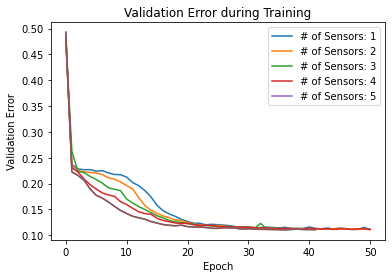

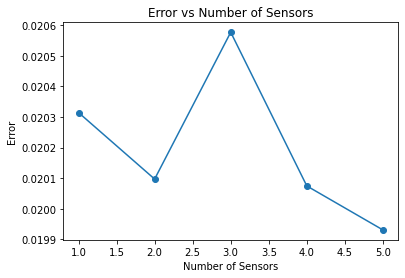

In [32]:
# Initialize Dataset
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Divide data into training, validation, and test sets
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

# Create Scaler
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

num_sensors_range = [1, 2, 3, 4, 5]  # Range of number of sensors to analyze

# Lists to store results
error_list = []

# Iterate over number of sensors
for num_sensors in num_sensors_range:
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)
    
    # Evaluate performance on test dataset
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    error_list.append(error)
    
    # Plot validation errors
    plt.plot(validation_errors, label=f'# of Sensors: {num_sensors}')

# Plot validation errors
plt.plot(validation_errors)
plt.xlabel('Epoch')
plt.ylabel('Validation Error')
plt.title('Validation Error during Training')
plt.legend()
plt.show()

# Plot performance as a function of number of sensors
plt.plot(num_sensors_range, error_list, marker='o')
plt.xlabel('Number of Sensors')
plt.ylabel('Error')
plt.title('Error vs Number of Sensors')
plt.show()